In [3]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')
#import os
#cwd = os.getcwd()
#print(cwd)

In [4]:
def matrixmaker(name):
    vessels = scipy.io.loadmat('Output/Vessels_' + name +'.mat') #pulls correct document as result of run_get_radii_part1
    array = vessels['vessel_details']
    table = pd.DataFrame(array)
    column_names = ['VES ID', 'CL FILE', 'LENGTH [mm]', 'MEAN RADII [mm]', 'MEDIAN RADII', 'R_STD','PARENT','DAUGHTERS','DAUGHTERS ID'] #names columns
    table.columns = column_names
    table = table.iloc[1: , :]# removes first row, leaves only data
    table = table.reset_index()
    matrix = table[['VES ID', 'LENGTH [mm]', 'MEAN RADII [mm]', 'PARENT', 'DAUGHTERS ID']]#selects specific columns we need
    vid = np.empty((0,0))
    length = np.empty((0,0))
    radius = np.empty((0,0))
    for i in np.arange(matrix.shape[0]):#takes everything out of extra arrays, mostly from weird Matlab formatting
        pv = matrix.iloc[i][0]
        vid = np.append(vid,pv)
        lengthint = matrix.iloc[i][1]
        length = np.append(length, lengthint[0][0])
        radiusint = matrix.iloc[i][2]
        radius = np.append(radius, radiusint[0][0])
    matrix['VES ID'] = vid
    matrix['LENGTH [mm]'] = length
    matrix.loc[:,'MEAN RADII [mm]'] = radius
    return matrix #returns .mat data as pandas dataframe

In [5]:
def splitint(arr):
    # Initialize an empty list to hold the final integer arrays
    result = []

    # Iterate through each string in the input array
    for item in arr:
        # Split the string by commas, strip any extra spaces, and convert to integers
        int_array = np.array([int(x.strip()) for x in item.split(',')], dtype=int)
        result.append(int_array)
    final_result = np.concatenate(result)
    return final_result

In [6]:
def alpha_beta(matrix):
    alpha = np.empty((0,0))
    beta = np.empty((0,0))
    vesselid = np.empty((0,0))
    for i in np.arange(matrix.shape[0]): #cycle through every row
        dvessels = splitint(matrix.iloc[i][4]) #pulls daughter vessels
        vessel = matrix.iloc[i][0]
        vesselid = np.append(vesselid,vessel)
        if dvessels[0] == 0: #if no bifurcation, we skip
            alpha = np.append(alpha,[np.nan]) #appends NaN as placeholder
            beta = np.append(beta,[np.nan])
            continue
        pvr = matrix.iloc[i][2]
        dv1 = matrix.loc[matrix['VES ID'] == str(dvessels[0])]
        #print(dvessels[0])
        #print(dv1)
        dv1r = dv1.iloc[0][2]
        dv2 = matrix.loc[matrix['VES ID'] == str(dvessels[1])]
        dv2r = dv2.iloc[0][2]
        if dv1r > dv2r: #determines which one is alpha vs beta, then stores the data
            alphavalue = dv1r/pvr
            #print(alphavalue)
            alpha = np.append(alpha,alphavalue)
            betavalue = dv2r/pvr
            beta = np.append(beta,betavalue)
        else: 
            alphavalue = dv2r/pvr
            #print(alphavalue)
            alpha = np.append(alpha,alphavalue)
            betavalue = dv1r/pvr
            beta = np.append(beta,betavalue)
    alphabeta = pd.DataFrame({'VES ID':vesselid,'Alpha':alpha, 'Beta':beta}) # returns the alpha beta data frame
    return alphabeta

In [7]:
def newton_method(matrix):
    xi_values = np.empty((0,0))
    vesselid = np.empty((0,0))
    error_values = np.empty((0,0))
    for i in np.arange(matrix.shape[0]): #cycle through every row
        dvessels = splitint(matrix.iloc[i][4]) #pulls daughter vessels
        vessel = matrix.iloc[i][0]
        vesselid = np.append(vesselid,vessel)
        if dvessels[0] == 0: #if no bifurcation, we skip
            xi_values = np.append(xi_values,[np.nan]) #appends NaN as placeholder
            error_values = np.append(error_values,[np.nan]) #appends NaN as placeholder
            continue
        rp = matrix.iloc[i][2]
        dv1 = matrix.loc[matrix['VES ID'] == str(dvessels[0])]
        #print(dvessels[0])
        #print(dv1)
        rd1 = dv1.iloc[0][2]
        dv2 = matrix.loc[matrix['VES ID'] == str(dvessels[1])]
        rd2 = dv2.iloc[0][2]
        xi = 1
        for i in np.arange(100):
            fun = rp**xi - rd1**xi - rd2**xi
            fun2 = (rp**xi)*math.log(rp) - (rd1**xi)*math.log(rd1) - (rd2**xi)*math.log(rd2)
            xi = xi - fun/fun2
            xi = max(1, min(6, xi))
            """if abs(rp**xi - rd1**xi - rd2**xi) < 1e-6:
                break"""
        error = rp**xi - rd1**xi - rd2**xi
        xi_values = np.append(xi_values,xi)
        error_values = np.append(error_values,error)
    xitable = pd.DataFrame({'VES ID':vesselid,'Xi':xi_values, 'Error':error_values}) # returns the alpha beta data frame
    return xitable

In [8]:
def lrr(table):
    vesselid = np.empty((0,0))
    lrrarray = np.empty((0,0))
    for i in np.arange(table.shape[0]): #cycles through each row
        vessel = table.iloc[i][0]
        length = table.iloc[i][1]
        radius = table.iloc[i][2]
        vesselid = np.append(vesselid,vessel) #appends ves ID
        lrr = length/radius
        lrrarray = np.append(lrrarray,lrr) #appends length to radius ratio
    lrrtable = pd.DataFrame({'VES ID':vesselid,'Length to Radius Ratio':lrrarray})
    return lrrtable #returns length-to-radius ratio as dataframe


In [9]:
name = 'm3p4_060407' #change this in accordance to your file
table = matrixmaker(name) #update path in function to yours
alpha = alpha_beta(table) #runs alpha_beta
lrrtable = lrr(table) #runs lrr
xi = newton_method(table)
merged = pd.merge(table,alpha,on='VES ID')
total = pd.merge(merged,lrrtable,on='VES ID') #merges all tables together
final = pd.merge(total,xi,on='VES ID')
pd.set_option('display.max_rows',None)
print(final)

    VES ID  LENGTH [mm] MEAN RADII [mm]   PARENT   DAUGHTERS ID     Alpha  \
0      418   102.060623        8.591217    [[0]]      [644,814]  0.921010   
1        1     5.974691         1.93806  [[769]]        [0,0,0]       NaN   
2        2     9.024580        1.995194  [[606]]        [0,0,0]       NaN   
3        3    14.999271        1.485843  [[656]]        [0,0,0]       NaN   
4        4     9.242641        2.258289  [[492]]        [0,0,0]       NaN   
5        5    24.049159        2.321944  [[426]]        [0,0,0]       NaN   
6        6     8.146264        1.853054  [[853]]        [0,0,0]       NaN   
7        7    26.606237        2.042375  [[435]]        [0,0,0]       NaN   
8        8     6.974691        1.414071  [[531]]        [0,0,0]       NaN   
9        9    20.509861        1.790106  [[558]]        [0,0,0]       NaN   
10      10     8.878315        2.011702  [[557]]        [0,0,0]       NaN   
11      11     6.292529        2.036471  [[727]]        [0,0,0]       NaN   

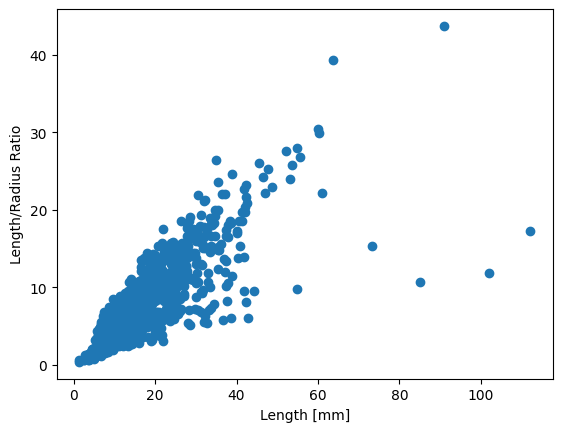

In [10]:
x = total['LENGTH [mm]']
y = total['Length to Radius Ratio']
plt.scatter(x, y)
plt.xlabel("Length [mm]")
plt.ylabel("Length/Radius Ratio")
plt.show()

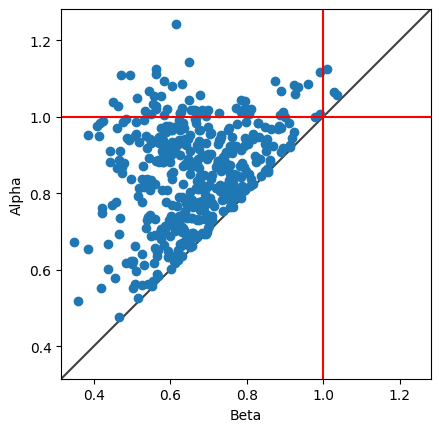

In [11]:
a = final['Alpha'].dropna()
b = final['Beta'].dropna()
fig, ax = plt.subplots()
plt.scatter(b, a)
plt.xlabel("Beta")
plt.ylabel("Alpha")
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.axhline(y = 1, color = 'r', linestyle = '-') 
plt.axvline(x = 1, color = 'r', linestyle = '-') 
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

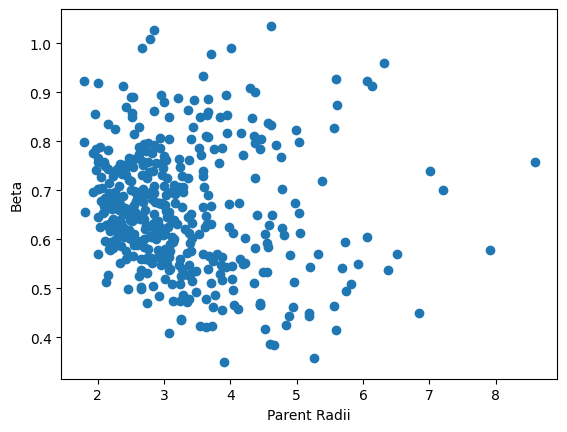

In [12]:
c = total.dropna()
d = c['MEAN RADII [mm]']
plt.scatter(d, b)
plt.xlabel("Parent Radii")
plt.ylabel("Beta")
plt.show()

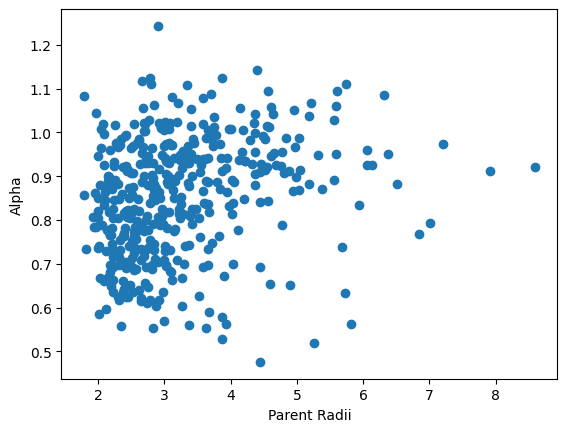

In [13]:
plt.scatter(d, a)
plt.xlabel("Parent Radii")
plt.ylabel("Alpha")
plt.show()

In [14]:
total[total['Alpha'] > 1].shape[0]

57